In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from random import sample
from collections import defaultdict
from statistics import median
from pandarallel import pandarallel
import csv

In [3]:
df = pd.read_csv('../data/healthy/data.csv')  
target = 'SEX'

#remove ABS from dataset
cols = [c for c in df.columns if c.lower()[:3] != 'abs']
df=df[cols]

labels = df[target].values
del df[target]
df = df[df.select_dtypes([np.number]).columns].dropna(axis=1)
labels

array(['F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'M',
       'F', 'F', 'F', 'M', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'F', 'M',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'M',
       'F', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M'],
      dtype=object)

In [79]:
def get_best_k_features(forest, train_features, k, plot=True):
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]


    # std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #              axis=0)

    print("*************** Features ranking ***************")
    x = []
    y = []
    i = 0
    for f in range(train_features.shape[1]):
        if i == k:
            break
        i += 1
        print("%d. feature: %s (%f)" % (f + 1, train_features.columns[indices[f]], importances[indices[f]]))
        x.append(train_features.columns[indices[f]])
        y.append(importances[indices[f]])

    if plot:
        x_pos = [i for i, _ in enumerate(x)]
        plt.barh(x_pos, y, color='green')
        # xerr=std**2
        plt.ylabel("Feature")
        plt.xlabel("Importance")
        plt.title(str(k) + " selected features")
        plt.yticks(x_pos, x)
        plt.show()

    return x

In [80]:
def check_classifiers(data, labels, requested_classifiers):
    X_train, X_test, Y_train, Y_test = train_test_split(data, labels,
                                                        test_size=0.2,
                                                        random_state=42)
    result = []

    classifiers = {"svm": SVC(), "nn": MLPClassifier(), "rf": RandomForestClassifier()}
    svm_params = {'kernel': ('linear', 'rbf', 'sigmoid', 'poly'),
                  'C': [.001, .01, .1, .5, 1, 2, 5, 10]}

    nn_params = {'activation': ['relu', 'tanh', 'logistic'],
                 'hidden_layer_sizes': [(100,), (10, 50, 2), (50, 100, 2)],
                 'solver': ['adam'],
                 'learning_rate': ['adaptive'],
                 'warm_start': [True, False]}

    rf_params = {'n_estimators': [100, 200, 300, 400, 500],
                 'criterion': ['gini', 'entropy']}
    cls_params = {'svm': svm_params, 'rf': rf_params, 'nn': nn_params}

    for k, v in classifiers.items():
        if k not in requested_classifiers:
            continue
        cv = GridSearchCV(v, cls_params[k], cv=5)
        cv.fit(X_train, Y_train)
        pred = cv.predict(X_test)
        print("***** {} *****".format(k))
        f1 = f1_score(Y_test, pred, average="macro")
        accuracy = accuracy_score(Y_test, pred)
        recall = recall_score(Y_test, pred, average="macro")
        c_res = ClassificationResult(k, round(accuracy, 4), round(f1, 4), round(recall, 4))
        print(c_res)
        result.append(c_res)
#         save_classifier(cv, data, k)
    return result

In [81]:
class CorrelationBasedFS:
    def __init__(self, kind):
        self.kind = kind

    # todo: select ONLY k features
    def execute(self, data, k, labels, requested_classifiers):
        cols = self.correlation_based_fs(self.kind, data)
        selected_features = []
        classification_results = check_classifiers(data[cols], labels, requested_classifiers)
        for i, f in enumerate(cols):
            # todo write correlation as score
            selected_features.append(SelectedFeature(i, f, 1))
        # todo: fill diagrams
        diagrams = []
        return selected_features, diagrams, classification_results

    def correlation_based_fs(self, method, data, threshold=0.9):
        corr = data.corr(method=method)
        to_drop = []
        for i, f1 in enumerate(data.columns):
            for j, f2 in enumerate(data.columns):
                if i > j and abs(corr.iloc[i, j]) > threshold:
                    to_drop.append(f1)

        # todo: handle this heatmap in a separate thread
        # plt.subplots(figsize=(50, 50))
        # sns.heatmap(corr, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .70})
        # plt.show()
        return list(set(data.columns) - set(to_drop))


class RandomForestFS:
    def execute(self, data, k, labels, requested_classifiers):
        forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
        train_features, test_features, train_labels, test_labels = train_test_split(data, labels,
                                                                                    test_size=0.2,
                                                                                    random_state=42)
        forest.fit(train_features, train_labels)
        selected_features, image_path = get_best_k_features(forest, train_features, k)
        columns = list(map(lambda sf: sf.name, selected_features))
        classification_results = check_classifiers(data[columns], labels, requested_classifiers)
        diagrams = [ResultImg("plt", image_path)]
        return selected_features, diagrams, classification_results

In [82]:
class CommandExecutor:
    def __init__(self):
        self.available_classifiers = ['svm', 'nn', 'rf']
        # todo: move this mapping to frontend
        self.available_cmds = {'RF': RandomForestFS(),
                               'Spearman\'s correlation': CorrelationBasedFS('spearman'),
                               'Kendall correlation': CorrelationBasedFS('kendall'),
                               'Pearson correlation': CorrelationBasedFS('pearson')}

    def execute(self, data, target, k, labels, algorithm_name):
        requested_classifiers = self.available_classifiers
        cmd = self.available_cmds[algorithm_name]
        selected_features, diagrams, cv_results = cmd.execute(data, k, labels, requested_classifiers)
        return FSResponse(algorithm_name, diagrams, selected_features, cv_results)

In [83]:
class ResultImg:
    def __init__(self, name, image):
        self.name = name
        self.image = image

class FSResponse:
    def __init__(self, algoName, resultImgs, featuresRank, classificationResults):
        self.algoName = algoName
        self.resultImgs = resultImgs
        self.featuresRank = featuresRank
        self.classificationResults = classificationResults

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__,
                          sort_keys=True, indent=4)
    
class SelectedFeature:
    def __init__(self, index, name, score):
        self.index = index
        self.name = name
        self.score = score
        
class ClassificationResult:
    def __init__(self, clfName, accuracy, f1, recall):
        self.clfName = clfName
        self.accuracy = accuracy
        self.f1 = accuracy
        self.recall = recall
        
    def __str__(self):
        return "Classifier: {}; Accuracy: {}; F1: {}; Recall: {}".format(self.clfName, self.accuracy,self.f1, self.recall)


In [84]:
def get_best_k_features(forest, train_features, k, plot=True):
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # std = np.std([tree.feature_importances_ for tree in forest.estimators_],
    #              axis=0)

    print("*************** Features ranking ***************")
    selected_features = []
    x = []
    y = []
    i = 0
    for f in range(train_features.shape[1]):
        if i == k:
            break
        i += 1
        print("%d. feature: %s (%f)" % (f + 1, train_features.columns[indices[f]], importances[indices[f]]))
        x.append(train_features.columns[indices[f]])
        y.append(importances[indices[f]])
        selected_features.append(SelectedFeature(i, train_features.columns[indices[f]], importances[indices[f]]))

    if plot:
        x_pos = [i for i, _ in enumerate(x)]
        plt.barh(x_pos, y, color='green')
        # xerr=std**2
        plt.ylabel("Feature")
        plt.xlabel("Importance")
        plt.title(str(k) + " selected features")
        plt.yticks(x_pos, x)
        # plt.savefig(r'rf_plot.png')
    return selected_features, '/assets/img/rf_plot.png'

*************** Features ranking ***************
1. feature: CD16-/CD56-/CD3+/CD117+ (0.036442)
2. feature: CD19+/CD86+ (0.027811)
3. feature: CD8- / CD127- / CD4+ / CD25+ (0.026584)
4. feature: CD4+/CD25+/CD127- (0.025189)
5. feature: CD3+/HLA DR+ (0.024168)
6. feature: CD8+/CD25+ (0.019792)
***** svm *****
Classifier: svm; Accuracy: 0.6667; F1: 0.6667; Recall: 0.625
***** nn *****
Classifier: nn; Accuracy: 0.5556; F1: 0.5556; Recall: 0.55
***** rf *****
Classifier: rf; Accuracy: 0.6667; F1: 0.6667; Recall: 0.65


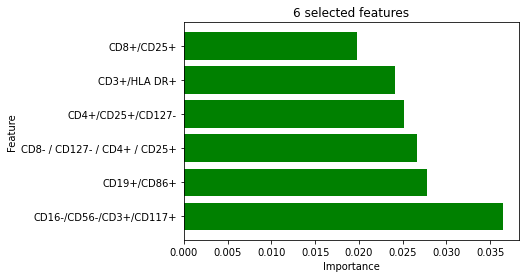

In [85]:
######## SEKCJA TESTOWANIA NOWYCH DANYCH #####################
cases = pd.read_csv('fvl_cases.csv', index_col=False)
controls = pd.read_csv('fvl_controls.csv', index_col=False)  
del cases['Unnamed: 0']
del controls['Unnamed: 0']
controls['Label'] = 1
cases['Label'] = 0
df = pd.concat([cases, controls])
df.reset_index(drop=True, inplace=True)
labels = df['Label']
df = df.drop(['Label'], axis=1)
executor = CommandExecutor()
executor.execute(df, 'Label', 6, labels, 'RF')


# Feature selection and classification benchmark

In [151]:
N_SPLITS = 5
RANDOM_STATE = 10

In [152]:
class FeatureSelector:
    """Extracts subset of most informative features and provides rank of all features from train samples."""
    def __init__(self, name):
        self.name = name
        self.features = features
        
    def get_features_rank():
        return self.features_rank
    
    def get_features_subset():
        return self.features_subset

In [153]:
class RandomForestSelector(FeatureSelector):
    def __init__(self, n_estimators=200):
        super().__init__('RandomForestSelector')
        self.forest = ExtraTreesClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE)
        
    def fit(self, X_train, y_train):
        self.forest.fit(X_train, y_train)
        
    def get_rank(self):
        return self.forest.feature_importances_

In [158]:
class FeatureSelectorsAggregator:
    """Aggregates partial feature selections obtained from FeatureSelectors."""
    def __init__(self, feature_selectors):
        self.name = 'FeatureSelectorsAggregator'
        self.feature_selectors = feature_selectors
        
    def get_features_rank(self):
        return self.features_rank
    
    def get_features_subset(self):
        return self.features_subset
    
    def fit(self, X_train, y_train):
        for f_selector in self.feature_selectors:
            f_selector.fit(X_train, y_train)
    
    def get_ranks(self):
        ranks = []
        for f_selector in self.feature_selectors:
            ranks.append(f_selector.get_rank())
        return ranks

In [159]:
from sklearn.model_selection import StratifiedKFold

class CVEvaluator:
    """Evaluate performance of feature selection and classification model with leave-one-out cross validation
        with n subsets (folds) of the whole dataset. For each iteration find the best classificator
        for current train/test split by performing GridSearchCV on the current train data and asses its performance
        on current test set. The results for each split are averaged and are the approximation of the performance
        of the final model.
            
        If n = 1, the best model is created by selecting features with FeatureSelectorsAggregator
        and performing GridSearchCV on the whole dataset to find the most accurate/sensitive classifier.
        """
    def __init__(self, n_splits, fs_aggregator, labels, features, data):
        """
        Init CVEvaluator.

        Args:
            n_splits: Number of subsets.
            fs_aggregator: FeatureSelectorsAggregator for feature selection at each split.
            labels: list of strings representing labels.
            features: list of feature names. Must match count of colums in data dataframe.
            data: Pandas dataframe containing samples in rows with len(features) columns each.
        """
        self.n_splits = n_splits
        self.fs_aggregator = fs_aggregator
        self.labels = labels
        self.features = features
        self.data = data
        
    def perform_evaluation(self):
        skf = StratifiedKFold(n_splits=self.n_splits, random_state=RANDOM_STATE, shuffle=True)
        for train_index, test_index in skf.split(self.data, self.labels):
            X_train, X_test = self.data[self.data.index.isin(train_index)], self.data[self.data.index.isin(test_index)]
            y_train, y_test = [self.labels[i] for i in train_index], [self.labels[i] for i in test_index]
            
            self.fs_aggregator.fit(X_train, y_train)
            print("Another rank:", len(self.fs_aggregator.get_ranks()))
            

In [160]:
df = pd.read_csv('../data/healthy/data.csv')  
target = 'SEX'

#remove ABS from dataset
cols = [c for c in df.columns if c.lower()[:3] != 'abs']
df=df[cols]

labels = list(df[target].values)
del df[target]
df = df[df.select_dtypes([np.number]).columns].dropna(axis=1)

In [161]:
features = list(df.columns)

f_selectors = [
    RandomForestSelector()
]

fs_aggregator = FeatureSelectorsAggregator(f_selectors)

cv_evaluator = CVEvaluator(N_SPLITS, fs_aggregator, labels, features, df)
cv_evaluator.perform_evaluation()

Another rank: 1
Another rank: 1
Another rank: 1
Another rank: 1
Another rank: 1
